In [11]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import os 
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

# Data Pre-Processing stage

In [12]:
# Initialize the initial learning rate, number of epochs to train for, and batch size

INIT_LR = 1e-4
EPOCHS = 20
BS = 32

PATH = r"D:/Mask detection/dataset"
FILES = ['with_mask','without_mask']

In [13]:
# Grab the list of images in our dataset directory, then initialize
# The list of data (i.e., images) and class images
print("[INFO] loading images...")

[INFO] loading images...


In [14]:
data = []
labels = []

for file in FILES:
    path = os.path.join(PATH, file)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size = (224,224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(file)

C:\Users\96599\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [15]:
data

[array([[[-0.45098037, -0.49019605, -0.44313723],
         [-0.45098037, -0.49019605, -0.44313723],
         [-0.45098037, -0.49019605, -0.44313723],
         ...,
         [-0.41176468, -0.62352943, -0.75686276],
         [-0.41176468, -0.62352943, -0.75686276],
         [-0.41176468, -0.62352943, -0.75686276]],
 
        [[-0.45098037, -0.49019605, -0.44313723],
         [-0.45098037, -0.49019605, -0.44313723],
         [-0.45098037, -0.49019605, -0.44313723],
         ...,
         [-0.41176468, -0.62352943, -0.75686276],
         [-0.41176468, -0.62352943, -0.75686276],
         [-0.41176468, -0.62352943, -0.75686276]],
 
        [[-0.3960784 , -0.45098037, -0.3960784 ],
         [-0.3960784 , -0.45098037, -0.3960784 ],
         [-0.3960784 , -0.45098037, -0.3960784 ],
         ...,
         [-0.45098037, -0.62352943, -0.8039216 ],
         [-0.45098037, -0.62352943, -0.8039216 ],
         [-0.45098037, -0.62352943, -0.8039216 ]],
 
        ...,
 
        [[-0.46666664, -0.67058825

In [16]:
labels

['with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with

In [17]:
# Performing one-hot encoding on the labels
LB = LabelBinarizer()
labels = LB.fit_transform(labels)
labels = to_categorical(labels)

In [18]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [19]:
# Changing the data and labels variable to np arrays for our model
data = np.array(data, dtype='float32')
labels = np.array(labels)

In [20]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.33, stratify = labels, random_state = 42)

# Training

In [21]:
# The training image generator for data augmentation

aug = ImageDataGenerator(
    rotation_range = 20,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [22]:
# Load the MobileNetV2 network

baseModel = MobileNetV2(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(224,224,3)))


9420800/9406464 [==============================] - 5s 1us/step


In [23]:
# Consturct the head of the model that will be placed on top of the base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name = 'flatten')(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2,activation='softmax')(headModel)

In [24]:
# Creating the model that we will train
model = Model(inputs = baseModel.input, outputs = headModel)

In [26]:
# Freeze the base models so they will not be updated during the first training process
for layer in baseModel.layers :
    layer.trainable = False

In [29]:
# Compile our Model 
print('[INFO] compiling model....')
opt = Adam(lr = INIT_LR, decay = INIT_LR/EPOCHS)
model.compile(loss='binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

[INFO] compiling model....


In [30]:
# Train the head of the network

print('[INFO] training head...')
H = model.fit(
    aug.flow(X_train,y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data = (X_test, y_test),
    validation_steps=len(X_test)//BS,
    epochs= EPOCHS
    )

[INFO] training head...
Epoch 1/20
80/80 [==============================] - 170s 2s/step - loss: 0.4647 - accuracy: 0.8131 - val_loss: 0.2005 - val_accuracy: 0.9810
Epoch 2/20
80/80 [==============================] - 135s 2s/step - loss: 0.1740 - accuracy: 0.9633 - val_loss: 0.1023 - val_accuracy: 0.9842
Epoch 3/20
80/80 [==============================] - 129s 2s/step - loss: 0.1165 - accuracy: 0.9681 - val_loss: 0.0760 - val_accuracy: 0.9826
Epoch 4/20
80/80 [==============================] - 128s 2s/step - loss: 0.0859 - accuracy: 0.9803 - val_loss: 0.0599 - val_accuracy: 0.9866
Epoch 5/20
80/80 [==============================] - 138s 2s/step - loss: 0.0763 - accuracy: 0.9799 - val_loss: 0.0545 - val_accuracy: 0.9866
Epoch 6/20
80/80 [==============================] - 124s 2s/step - loss: 0.0685 - accuracy: 0.9826 - val_loss: 0.0472 - val_accuracy: 0.9897
Epoch 7/20
80/80 [==============================] - 143s 2s/step - loss: 0.0610 - accuracy: 0.9842 - val_loss: 0.0436 - val_accura

In [31]:
# Make predictions on the testing set
print('[INFO] evaluating network ...')
predIdxs = model.predict(X_test, batch_size = BS)

[INFO] evaluating network ...


In [33]:
predIdx = np.argmax(predIdxs , axis = 1)

In [40]:
print('[INFO] saving mask detector model ...')
model.save('mask_detector.model', save_format = 'h5')

[INFO] saving mask detector model ...


C:\Users\96599\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


TypeError: __init__() got an unexpected keyword argument 'Loc'

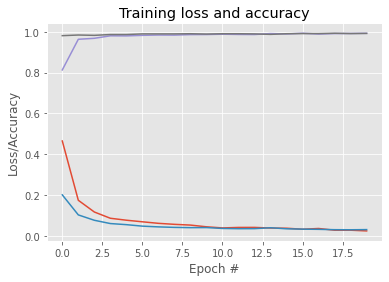

In [43]:
# Print the training loss and accuracy
N = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0,N), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0,N), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0,N), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0,N), H.history['val_accuracy'], label = 'val_acc')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.savefig('plot.png')
plt.legend(Loc = 'lower left')
